In [1]:
# imports
import pandas as pd
from pandas import json_normalize
import json
import requests
import os
from pprint import pp
import time
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Foursquare

#### Send a request to Foursquare with a small radius (1000m) for all the bike stations in your city of choice. 

In [2]:
# Setting variables
api_key = os.getenv('FOUR_SQUARE_API')
url = 'https://api.foursquare.com/v3/places/search'
headers = {
    'Accept': 'application/json',
    'Authorization': api_key
}
radius  = 1000 # 1 km
categories = '10000,13000' #10000: Art and Entertainment, 13000: Dining and Restaurant(some bars)
fields = 'fsq_id,name,rating,popularity,price,categories,distance,geocodes'
limit = 50
time_per_request = 1 / 100  # 1 second / 100 QPS - FourSquare API rate limit
responses = [] # list for dumping responses along the way in case of error

In [3]:
# Load locations from stations.csv
stations = pd.read_csv('../data/stations.csv', index_col=None)

# Create a list of paired (latitude, longitude)
locations = [f"{lat},{long}" for lat, long in zip(stations['latitude'], stations['longitude'])]

In [12]:
# GET request for each locations

# Continue from last error, if any
try:
    with open('../data/responses_fsq.json', 'r') as f:
        responses = json.load(f)
except FileNotFoundError:
    pass

# Loop throught locations
for location in locations[len(responses):]:
    params = {
        'll': location,
        'radius': radius,
        'fields': fields,
        'categories': categories,
        'limit': limit
    }
    try:
        response = requests.get(url, params=params, headers=headers)
        response.raise_for_status()

        responses.append(response.json())

        # Save intermediate progress after each successful request
        with open('../data/responses_fsq.json', 'w') as f:
            json.dump(responses, f)

    except requests.exceptions.RequestException as error:
        print(f"Error: {error}")
        # Break out of the loop when an error occurs
        break

    time.sleep(time_per_request)

    # Stop the loop if an error occurred
    if 'error' in response.json():
        break

#### Parse through the response to get the POI (such as restaurants, bars, etc) details you want (ratings, name, location, etc)

In [4]:
# Load source
with open('../data/responses_fsq.json', 'r') as f:
        responses = json.load(f)

In [4]:
# Visualize structure of FSQ responses
pp(responses[0], depth=5)
pp(responses[0]['results'][0].keys())

{'results': [{'fsq_id': '4cb240b8cbab236ae154af73',
              'categories': [{'id': 13236,
                              'name': 'Italian Restaurant',
                              'icon': {...}}],
              'distance': 941,
              'geocodes': {'main': {'latitude': 45.617439,
                                    'longitude': -73.593995},
                           'roof': {'latitude': 45.617439,
                                    'longitude': -73.593995}},
              'name': 'Restaurant Prima Luna',
              'popularity': 0.9848918500445737,
              'price': 1,
              'rating': 7.4},
             {'fsq_id': '4e0b48221f6edc06be259aec',
              'categories': [{'id': 10039,
                              'name': 'Music Venue',
                              'icon': {...}},
                             {'id': 11130,
                              'name': 'Office Building',
                              'icon': {...}}],
              'distance': 19,
  

In [5]:
# Validate if categories can have mulitple items

# Flatten the JSON structure using json_normalize
df = json_normalize(responses, record_path='results')

# Calculate the number of categories for each business
df['num_categories'] = df['categories'].apply(len)

# Check if any business has multiple categories
businesses_with_multiple_categories = df[df['num_categories'] > 1]
print(f"Businesses with multiple categories: {len(businesses_with_multiple_categories)}")
print(businesses_with_multiple_categories[['name', 'categories', 'num_categories']])

Businesses with multiple categories: 18562
                                   name  \
1                        Salle Désilets   
2                           Café l'Exil   
3                              Capucine   
4      Biscuits Heavenly Taste Biscotti   
5                                 Ecafé   
...                                 ...   
35168                           Fitzroy   
35169                       Frite Alors   
35171         Bootlegger, l'Authentique   
35172                      Bar l'Barouf   
35173                   Les 3 Brasseurs   

                                              categories  num_categories  
1      [{'id': 10039, 'name': 'Music Venue', 'icon': ...               2  
2      [{'id': 13034, 'name': 'Café', 'icon': {'prefi...               2  
3      [{'id': 13002, 'name': 'Bakery', 'icon': {'pre...               2  
4      [{'id': 13002, 'name': 'Bakery', 'icon': {'pre...               2  
5      [{'id': 13065, 'name': 'Restaurant', 'icon': {...         

In [6]:
# Parsing required info: 
#   While exploring with 'Postman' requests, FourSquare doesn't always gives rating, popularity and price

# List to store extracted items
extracted_items = []

# Iterate through each data entry
for entry in responses:
    # Use json_normalize to flatten the 'businesses' data
    flattened_businesses = json_normalize(entry['results'])

    # Iterate through each row in flattened_businesses
    for idx, business in flattened_businesses.iterrows():
        # Loop through categories and create a new entry for each category
        for category in business['categories']:
            extracted_item = {
                'fsq_id': business['fsq_id'],
                'name': business['name'],
                's_lat': entry['context']['geo_bounds']['circle']['center']['latitude'],
                's_lon': entry['context']['geo_bounds']['circle']['center']['longitude'],
                'p_lat': business.get('geocodes.main.latitude', np.nan),
                'p_lon': business.get('geocodes.main.longitude', np.nan),
                'category_id': category['id'],
                'category_name': category['name'],
                'distance': business['distance'],
                'rating': business.get('rating', np.nan),
                'popularity': business.get('popularity', np.nan),
                'price': business.get('price', np.nan)
            }
            extracted_items.append(extracted_item)

#### Put your parsed results into a DataFrame

In [7]:
# Create dataframe
df_businesses = pd.DataFrame(extracted_items)
df_businesses.head()

,fsq_id,name,s_lat,s_lon,p_lat,p_lon,category_id,category_name,distance,rating,popularity,price
0,4cb240b8cbab236ae154af73,Restaurant Prima Luna,45.6175,-73.606011,45.617439,-73.593995,13236,Italian Restaurant,941,7.4,0.984892,1.0
1,4e0b48221f6edc06be259aec,Salle Désilets,45.6175,-73.606011,45.617818,-73.606000,10039,Music Venue,19,NaN,0.968787,NaN
2,4e0b48221f6edc06be259aec,Salle Désilets,45.6175,-73.606011,45.617818,-73.606000,11130,Office Building,19,NaN,0.968787,NaN
3,4ea9b28cb803cf1ffacd7c0d,Café l'Exil,45.6175,-73.606011,45.617214,-73.604961,13034,Café,79,NaN,0.868507,1.0
4,4ea9b28cb803cf1ffacd7c0d,Café l'Exil,45.6175,-73.606011,45.617214,-73.604961,13035,Coffee Shop,79,NaN,0.868507,1.0


## Pre_cleaning

In [8]:
# Any duplicates?
print(df_businesses.duplicated().sum())

215


In [9]:
# Drop duplicates
fsq_with_dupes = df_businesses.copy() # Just in case!
df_businesses.drop_duplicates(inplace=True)
print(df_businesses.duplicated().sum())

0


In [10]:
# Any-null? and Dtypes info
df_businesses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61214 entries, 0 to 61428
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fsq_id         61214 non-null  object 
 1   name           61214 non-null  object 
 2   s_lat          61214 non-null  float64
 3   s_lon          61214 non-null  float64
 4   p_lat          61214 non-null  float64
 5   p_lon          61214 non-null  float64
 6   category_id    61214 non-null  int64  
 7   category_name  61214 non-null  object 
 8   distance       61214 non-null  int64  
 9   rating         40794 non-null  float64
 10  popularity     52790 non-null  float64
 11  price          44336 non-null  float64
dtypes: float64(7), int64(2), object(3)
memory usage: 6.1+ MB


#### Overview:
For missing values:
- Rating: we could try to get the rating value from Yelp to reduce the number of missing value (need scaling).

For modeling purpose only:
- Popularity: We could drop these only if they don't have a rating either.
- Price: Only keep if they have a rating.

In [11]:
# Check memory
print(df_businesses.memory_usage())

Index            489712
fsq_id           489712
name             489712
s_lat            489712
s_lon            489712
p_lat            489712
p_lon            489712
category_id      489712
category_name    489712
distance         489712
rating           489712
popularity       489712
price            489712
dtype: int64


In [12]:
# Check column popularity and price
print(df_businesses['popularity'].agg(['min', 'max']))
print(df_businesses['price'].unique())

min    0.000610
max    0.999921
Name: popularity, dtype: float64
[ 1. nan  2.  3.  4.]


In [13]:
# Convert type

df_businesses['popularity'] = df_businesses['popularity'].round(3)
df_businesses['price'] = pd.to_numeric(
    df_businesses['price'], 
    errors='coerce'
).astype('Int16')

In [14]:
print(df_businesses.dtypes)
df_businesses.memory_usage()

fsq_id            object
name              object
s_lat            float64
s_lon            float64
p_lat            float64
p_lon            float64
category_id        int64
category_name     object
distance           int64
rating           float64
popularity       float64
price              Int16
dtype: object


Index            489712
fsq_id           489712
name             489712
s_lat            489712
s_lon            489712
p_lat            489712
p_lon            489712
category_id      489712
category_name    489712
distance         489712
rating           489712
popularity       489712
price            183642
dtype: int64

In [15]:
# Descriptive statistics
df_businesses.describe()

,s_lat,s_lon,p_lat,p_lon,category_id,distance,rating,popularity,price
count,61214.000000,61214.000000,61214.000000,61214.000000,61214.000000,6.121400e+04,40794.000000,52790.000000,44336.0
mean,45.522447,-73.590226,45.522165,-73.590163,12836.673359,9.898619e+02,8.008254,0.897046,1.583724
std,0.034489,0.041489,0.034231,0.041448,1078.292490,2.403115e+04,0.918004,0.174962,0.687861
min,45.416295,-73.758227,45.415116,-73.769120,10000.000000,4.000000e+00,4.500000,0.001000,1.0
25%,45.502386,-73.608970,45.502195,-73.608952,13018.000000,4.530000e+02,7.500000,0.918000,1.0
50%,45.523550,-73.581056,45.522827,-73.579761,13049.000000,6.690000e+02,8.200000,0.950000,1.0
75%,45.540060,-73.566583,45.539309,-73.566723,13095.000000,8.490000e+02,8.700000,0.971000,2.0
max,45.702349,-73.436058,45.705136,-73.427798,19055.000000,2.333683e+06,9.400000,1.000000,4.0


It looks like we have data from outside the radius of 1000m

In [16]:
# out of radius data
out_radius = df_businesses[df_businesses['distance'] > 1000]
print(out_radius.shape[0])

885


In [17]:
# Delete outliers
df_businesses = df_businesses[df_businesses['distance'] <= 1000]

<Figure size 1200x800 with 0 Axes>

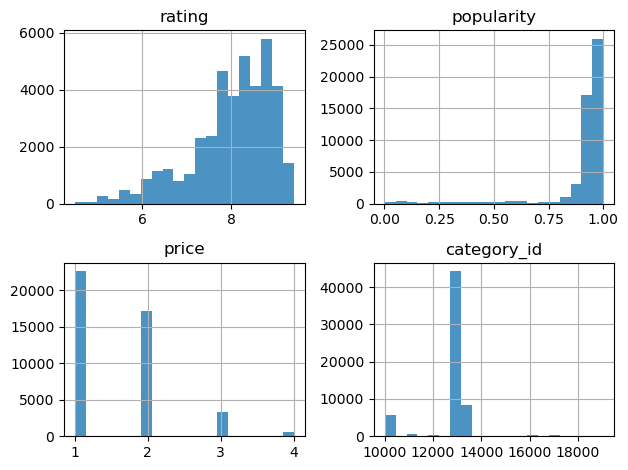

In [18]:
# Histogram of each variables (raw data)
plt.figure(figsize=(12, 8))
df_businesses[['rating', 'popularity', 'price', 'category_id']].hist(bins=20, alpha=0.8)
plt.tight_layout()

## First impressions
- a) Rating and popularity have a high mean, with maybe some outliers on the left.
- b) price seems positively skewed too, with most of price between 1 and 2.
    - Values include:
        - 1 = Cheap
        - 2 = Moderate
        - 3 = Expensive
        - 4 = Very Expensive.<br>
    This is not abnormal, as Montreal is recognize having a lot of good restaurants with a majority of low prices and a few with very high prices.
- c) Category_id has some data outside of the collected category (10,000's, 13,000's). Remove.
- d) Popularity as some strong outliers in the low value. Should validate the impact on rating if removing them.


In [19]:
# a) and b) could be caused by the same outliers from c)
out_of_cat = df_businesses[df_businesses['category_id'] > 14000]['category_id']
print(f"Number of out of range catgeory = {len(out_of_cat)}")

Number of out of range catgeory = 980


In [20]:
# d) Check low popularity value
tot_pop = df_businesses[(df_businesses['popularity'] < 0.75)].shape[0]
num_pop_no_rating = df_businesses[(df_businesses['popularity'] < 0.75) & (df_businesses['rating'].isnull())].shape[0]
avg_rating = df_businesses[(df_businesses['popularity'] < 0.75) & (~df_businesses['rating'].isnull())]['rating'].mean()
print(f"Total rows popularity below 75% = {tot_pop}")
print(f"Total which have no ratings = {num_pop_no_rating}")
print(f"Average rating for pop below 75% = {avg_rating}")

Total rows popularity below 75% = 4294
Total which have no ratings = 4142
Average rating for pop below 75% = 6.7592105263157904


- Most of the popularity below 75% have no ratings.
- The average of ratings left is below the mean of the whole data (out of std dev also).
- The subset is relatively small compare to the total of data (4294 out of 61214)

In [21]:
# Validate the rating of each familiy of category (10,000's, 13,000's)
num_rows_10k = df_businesses[df_businesses['category_id'].between(10000, 12999)].shape[0]
num_rating_10k = df_businesses[(df_businesses['category_id'].between(10000, 12999)) & (df_businesses['rating'].isnull())].shape[0]

num_rows_13k = df_businesses[df_businesses['category_id'].between(13000, 13999)].shape[0]
num_rating_13k = df_businesses[(df_businesses['category_id'].between(13000, 13999)) & (df_businesses['rating'].isnull())].shape[0]

print(f"Pourcentage of missing rating for 10k category = {round(num_rating_10k/num_rows_10k*100)}%")
print(f"Pourcentage of missing rating for 13k category = {round(num_rating_10k/num_rows_10k*100)}%")
print(f"Pourcentage of 10k rows over total = {round((num_rows_10k/(num_rows_10k+num_rows_13k))*100)}%")

Pourcentage of missing rating for 10k category = 60%
Pourcentage of missing rating for 13k category = 60%
Pourcentage of 10k rows over total = 11%


- It looks like it is difficult to get ratings at all from FourSquare...
- It looks like Art & Entertainement category is less represented, and will even be more less if we remove the no rating rows. 
When modeling, we should maybe conduct seperate model for each category

In [22]:
# Filter category outlier
df_businesses = df_businesses[df_businesses['category_id'] <= 13999]
df_businesses.describe()

,s_lat,s_lon,p_lat,p_lon,category_id,distance,rating,popularity,price
count,59349.000000,59349.000000,59349.000000,59349.000000,59349.000000,59349.000000,39961.000000,51230.000000,43531.0
mean,45.522274,-73.590191,45.521992,-73.590136,12767.394042,629.369762,8.009992,0.899922,1.584825
std,0.034383,0.041231,0.034127,0.041185,930.575431,248.513847,0.918921,0.171404,0.687681
min,45.416295,-73.758227,45.415116,-73.769120,10000.000000,4.000000,4.500000,0.001000,1.0
25%,45.502350,-73.608970,45.502195,-73.608952,13018.000000,449.000000,7.500000,0.919000,1.0
50%,45.523481,-73.581056,45.522768,-73.579789,13047.000000,664.000000,8.200000,0.951000,1.0
75%,45.539891,-73.566663,45.539055,-73.566905,13068.000000,841.000000,8.700000,0.971000,2.0
max,45.702349,-73.436058,45.705136,-73.427798,13389.000000,1000.000000,9.400000,1.000000,4.0


In [23]:
df_businesses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59349 entries, 0 to 61428
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fsq_id         59349 non-null  object 
 1   name           59349 non-null  object 
 2   s_lat          59349 non-null  float64
 3   s_lon          59349 non-null  float64
 4   p_lat          59349 non-null  float64
 5   p_lon          59349 non-null  float64
 6   category_id    59349 non-null  int64  
 7   category_name  59349 non-null  object 
 8   distance       59349 non-null  int64  
 9   rating         39961 non-null  float64
 10  popularity     51230 non-null  float64
 11  price          43531 non-null  Int16  
dtypes: Int16(1), float64(6), int64(2), object(3)
memory usage: 5.6+ MB


<Figure size 1200x800 with 0 Axes>

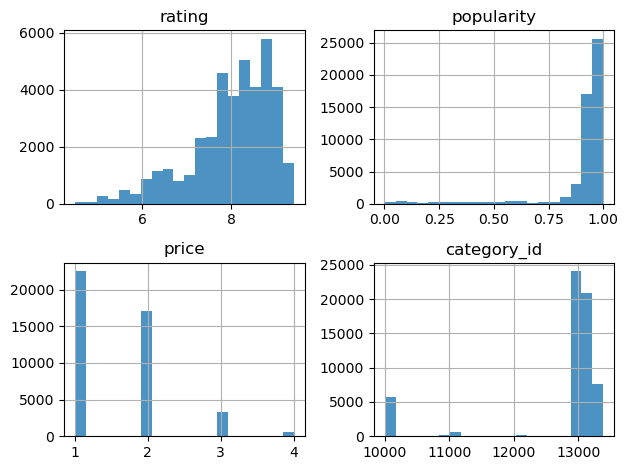

In [24]:
# Histogram of each variables (filtered data)
plt.figure(figsize=(12, 8))
df_businesses[['rating', 'popularity', 'price', 'category_id']].hist(bins=20, alpha=0.8)
plt.tight_layout()

In [25]:
# Create csv file
df_businesses.to_csv('../data/fsq_businesses.csv', index=False)

# Yelp

#### Send a request to Yelp with a small radius (1000m) for all the bike stations in your city of choice. 

In [26]:
# Note: The API does not return businesses without any reviews.

# Setting variables
api_key = os.getenv('YELP_API')
url = 'https://api.yelp.com/v3/businesses/search'
headers = {
    'Accept': 'application/json',
    'Authorization': 'Bearer ' + api_key
}
radius  = 1000 # 1 km
time_per_request = 1 / 100  # 1 second / 100 QPS - Cannot find real QPS - Limit 500 per day
responses = [] # list for dumping responses along the way in case of error

In [10]:
# GET request for each locations

# Continue from last error, if any, or from limit obtained for last day
try:
    with open('../data/responses_yelp.json', 'r') as f:
        responses = json.load(f)
except FileNotFoundError:
    pass

# Loop throught locations - Limit Max 500 per day

max_iterations = 500
start_index = len(responses)
end_index = min(start_index + max_iterations, len(stations))

for index in range(start_index, end_index):
    params = {
        'latitude': stations.iloc[index]['latitude'],
        'longitude': stations.iloc[index]['longitude'],
        'radius': radius
    }

    try:
        response = requests.get(url, params=params, headers=headers)
        response.raise_for_status()

        responses.append(response.json())

        # Save intermediate progress after each successful request
        with open('../data/responses_yelp.json', 'w') as f:
            json.dump(responses, f)

        # Print progress
        remaining = response.headers.get('RateLimit-Remaining')
        clear_output(wait=True)
        print(f"Remaining calls: {remaining}")
        
    except requests.exceptions.RequestException as error:
        print(f"Error: {error}")
        # Break out of the loop when an error occurs
        break

    time.sleep(time_per_request)

    # Stop the loop if an error occurred
    if 'error' in response.json():
        break

Remaining calls: 202.0


#### Parse through the response to get the POI (such as restaurants, bars, etc) details you want (ratings, name, location, etc)

In [27]:
# Load source
with open('../data/responses_yelp.json', 'r') as f:
        responses = json.load(f)

In [28]:
# Visualize structure of Yelp responses
pp(responses[0], depth=5)
pp(responses[0]['businesses'][0].keys())

{'businesses': [{'id': 'vRJPrk-VH75uxLiVVprBhA',
                 'alias': 'capucine-montreal-nord',
                 'name': 'Capucine',
                 'image_url': 'https://s3-media2.fl.yelpcdn.com/bphoto/BOs9f6hjfSGjgEE64IT0lw/o.jpg',
                 'is_closed': False,
                 'url': 'https://www.yelp.com/biz/capucine-montreal-nord?adjust_creative=qL1YbVp0nO3zbAD9GxJuXw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=qL1YbVp0nO3zbAD9GxJuXw',
                 'review_count': 4,
                 'categories': [{'alias': 'italian', 'title': 'Italian'}],
                 'rating': 5.0,
                 'coordinates': {'latitude': 45.6196699281717,
                                 'longitude': -73.6097039384337},
                 'transactions': [],
                 'location': {'address1': '7000 Boulevard Maurice Duplessis',
                              'address2': '',
                              'address3': '',
                              'city':

In [29]:
# Validate if categories can have mulitple items

# Flatten the JSON structure using json_normalize
df = json_normalize(responses, record_path='businesses')

# Calculate the number of categories for each business
df['num_categories'] = df['categories'].apply(len)

# Check if any business has multiple categories
businesses_with_multiple_categories = df[df['num_categories'] > 1]
print(f"Businesses with multiple categories: {len(businesses_with_multiple_categories)}")
print(businesses_with_multiple_categories[['name', 'categories', 'num_categories']])

Businesses with multiple categories: 7840
                        name  \
1      Restaurant Prima Luna   
2      Boulangerie Adriatica   
3       Boulangerie Amaretti   
5                Tim Hortons   
6           Shekz Restaurant   
...                      ...   
15105        Les Deux Gamins   
15106           Ichigo Ichie   
15107                 O'Thym   
15109               Nil Bleu   
15111    La Demande Générale   

                                              categories  num_categories  
1      [{'alias': 'italian', 'title': 'Italian'}, {'a...               2  
2      [{'alias': 'italian', 'title': 'Italian'}, {'a...               2  
3      [{'alias': 'bakeries', 'title': 'Bakeries'}, {...               2  
5      [{'alias': 'coffee', 'title': 'Coffee & Tea'},...               2  
6      [{'alias': 'sushi', 'title': 'Sushi Bars'}, {'...               3  
...                                                  ...             ...  
15105  [{'alias': 'french', 'title': 'French'}, 

In [30]:
# Parsing required info

# List to store extracted items
extracted_items = []

# Iterate through each data entry
for entry in responses:
    # Use json_normalize to flatten the 'businesses' data
    flattened_businesses = json_normalize(entry['businesses'])

    # Iterate through each row in flattened_businesses
    for idx, business in flattened_businesses.iterrows():
        # Loop through categories and create a new entry for each category
        for category in business['categories']:
            extracted_item = {
                'id': business['id'],
                'name': business['name'],
                'rating': business.get('rating', np.nan),
                'price': business.get('price', np.nan),
                'review_count': business['review_count'],
                's_lat': entry['region']['center']['latitude'],
                's_lon': entry['region']['center']['longitude'],
                'p_lat': business.get('coordinates.latitude', np.nan),
                'p_lon': business.get('coordinates.longitude', np.nan),
                'category_alias': category['alias'],
                'distance': business['distance']
            }
            extracted_items.append(extracted_item)

#### Put your parsed results into a DataFrame

In [31]:
# Create dataframe
df_businesses = pd.DataFrame(extracted_items)
df_businesses.head()

,id,name,rating,price,review_count,s_lat,s_lon,p_lat,p_lon,category_alias,distance
0,vRJPrk-VH75uxLiVVprBhA,Capucine,5.0,NaN,4,45.6175,-73.606011,45.619670,-73.609704,italian,375.111000
1,TyKGLi1V1PFRHYmHDjFUMQ,Restaurant Prima Luna,4.0,$$$,14,45.6175,-73.606011,45.617234,-73.594176,italian,920.960695
2,TyKGLi1V1PFRHYmHDjFUMQ,Restaurant Prima Luna,4.0,$$$,14,45.6175,-73.606011,45.617234,-73.594176,sushi,920.960695
3,DOVOYnq3y-milXVI03GIrg,Boulangerie Adriatica,4.0,NaN,1,45.6175,-73.606011,45.615210,-73.609710,italian,365.542788
4,DOVOYnq3y-milXVI03GIrg,Boulangerie Adriatica,4.0,NaN,1,45.6175,-73.606011,45.615210,-73.609710,pizza,365.542788


#### Pre_cleaning

In [32]:
# Any duplicates?
print(df_businesses.duplicated().sum())

0


In [33]:
# Any-null? and Dtypes info
print(df_businesses.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26339 entries, 0 to 26338
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              26339 non-null  object 
 1   name            26339 non-null  object 
 2   rating          26339 non-null  float64
 3   price           20389 non-null  object 
 4   review_count    26339 non-null  int64  
 5   s_lat           26339 non-null  float64
 6   s_lon           26339 non-null  float64
 7   p_lat           26339 non-null  float64
 8   p_lon           26339 non-null  float64
 9   category_alias  26339 non-null  object 
 10  distance        26339 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 2.2+ MB
None


In [34]:
# Check memory
print(df_businesses.memory_usage())

Index                132
id                210712
name              210712
rating            210712
price             210712
review_count      210712
s_lat             210712
s_lon             210712
p_lat             210712
p_lon             210712
category_alias    210712
distance          210712
dtype: int64


In [35]:
# Convert type
df_businesses['review_count'] = df_businesses['review_count'].astype(int)
df_businesses['distance'] = df_businesses['distance'].round().astype(int)

# Mapping dictionary
price_mapping = {'$': 1, '$$': 2, '$$$': 3, '$$$$': 4, '$$$$$': 5} # to_match FSQ and to be numeric

# Apply the mapping function to the 'price' column
df_businesses['price'] = df_businesses['price'].map(price_mapping)
df_businesses['price'] = pd.to_numeric(
    df_businesses['price'], 
    errors='coerce'
).astype('Int16')

print(df_businesses.memory_usage())

Index                132
id                210712
name              210712
rating            210712
price              79017
review_count      210712
s_lat             210712
s_lon             210712
p_lat             210712
p_lon             210712
category_alias    210712
distance          210712
dtype: int64


In [36]:
df_businesses.head()

,id,name,rating,price,review_count,s_lat,s_lon,p_lat,p_lon,category_alias,distance
0,vRJPrk-VH75uxLiVVprBhA,Capucine,5.0,<NA>,4,45.6175,-73.606011,45.619670,-73.609704,italian,375
1,TyKGLi1V1PFRHYmHDjFUMQ,Restaurant Prima Luna,4.0,3,14,45.6175,-73.606011,45.617234,-73.594176,italian,921
2,TyKGLi1V1PFRHYmHDjFUMQ,Restaurant Prima Luna,4.0,3,14,45.6175,-73.606011,45.617234,-73.594176,sushi,921
3,DOVOYnq3y-milXVI03GIrg,Boulangerie Adriatica,4.0,<NA>,1,45.6175,-73.606011,45.615210,-73.609710,italian,366
4,DOVOYnq3y-milXVI03GIrg,Boulangerie Adriatica,4.0,<NA>,1,45.6175,-73.606011,45.615210,-73.609710,pizza,366


In [37]:
# Descriptive statistics
print(df_businesses.describe())

             rating     price  review_count         s_lat         s_lon  \
count  26339.000000   20389.0  26339.000000  26339.000000  26339.000000   
mean       4.127757  2.100054    125.427313     45.522838    -73.593403   
std        0.611375  0.658321    245.470379      0.036496      0.045010   
min        1.000000       1.0      1.000000     45.416295    -73.758227   
25%        4.000000       2.0     11.000000     45.501804    -73.614708   
50%        4.000000       2.0     44.000000     45.524283    -73.581989   
75%        4.500000       2.0    129.000000     45.543652    -73.566583   
max        5.000000       4.0   3117.000000     45.702349    -73.436058   

              p_lat         p_lon      distance  
count  26339.000000  26339.000000  26339.000000  
mean      45.522240    -73.593572    655.471278  
std        0.036352      0.046371   1119.072248  
min       45.374494    -73.992268      5.000000  
25%       45.500557    -73.612714    312.000000  
50%       45.523141    -

#### First impressions

- a) review_count seems really skewed with a high std_dev
- b) distance have outliers as the set radius was 1000 meters.
    - According to documentation:<br>
    "A suggested search radius in meters. This field is used as a suggestion to the search. The actual search radius may be lower than the suggested radius in dense urban areas, and higher in regions of less business density ..."

In [38]:
# (a) Get unique business names and review counts
unique_businesses = df_businesses[['id', 'name', 'review_count']].drop_duplicates()

print(unique_businesses.sort_values('review_count', ascending=False))

                           id                          name  review_count
4884   0W4lkclzZThpx3V65bVgig                    Schwartz's          3117
496    5T6kFKFycym_GkhgOiysIw                   La Banquise          2174
17111  46Ld9Qc9nAx_A0jwclNZiw             Olive + Gourmando          1598
1557   46Ld9Qc9nAx_A0jwclNZiw             Olive + Gourmando          1597
500    cKdox2gt3L1Dbb7MpOPdWg             Au Pied de Cochon          1381
...                       ...                           ...           ...
547    tVvymgTOoqjTHeyt9oRTOA          Cremerie Le Tropique             1
548    ODF2TwBABHr1Q1YZElyD0Q                   Pizza Elite             1
19265  x_GvS6koYswaGRX9I6l8CA  Charcuterie Patisserie Piast             1
557    DOtyInSKm-s6nsEe3CxX5Q                Domino's Pizza             1
10731  iyp_-nKWESOrdetyABQ_8A  Restaurant La Belle Province             1

[2532 rows x 3 columns]


- c) Due to the fact that I had to request the API in batches (500 per day max), some business ID don't have the same review_count

In [39]:
# (c) Update the review_count

max_review_count = df_businesses.groupby('id')['review_count'].transform('max')

# Update the review_count column with the maximum values
df_businesses['review_count'] = max_review_count

In [40]:
# (b) View if businesses out of radius
out_radius = df_businesses[df_businesses['distance'] > 1000]
print(len(out_radius))

3945


In [41]:
# (b) Filter out businesses out of radius
df_businesses = df_businesses[df_businesses['distance'] <= 1000]
print(df_businesses.describe())

             rating    price  review_count         s_lat         s_lon  \
count  22394.000000  17393.0  22394.000000  22394.000000  22394.000000   
mean       4.126150   2.1005    124.673797     45.522215    -73.592639   
std        0.606704  0.65301    244.335947      0.036138      0.044564   
min        1.000000      1.0      1.000000     45.416295    -73.758227   
25%        4.000000      2.0     11.000000     45.501407    -73.612969   
50%        4.000000      2.0     45.000000     45.523319    -73.581056   
75%        4.500000      2.0    129.000000     45.543032    -73.566583   
max        5.000000      4.0   3117.000000     45.702349    -73.436058   

              p_lat         p_lon      distance  
count  22394.000000  22394.000000  22394.000000  
mean      45.521918    -73.592633    516.712423  
std        0.035891      0.044400    279.510146  
min       45.415137    -73.859123      5.000000  
25%       45.500554    -73.612450    279.000000  
50%       45.522707    -73.580262

<Figure size 1200x800 with 0 Axes>

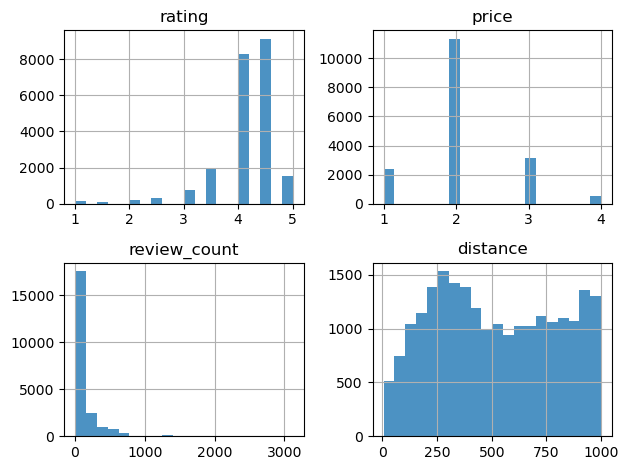

In [42]:
# Histogram of each variables (filtered data)
plt.figure(figsize=(12, 8))
df_businesses[['rating', 'price', 'review_count', 'distance']].hist(bins=20, alpha=0.8)
plt.tight_layout()

### OVERVIEW
For modeling only:
- Rating have some outliers with low value, maybe remove rating < 3.
- Review_counts have great outliers with 3000 review, should remove review_count > 1000.

<Figure size 1200x800 with 0 Axes>

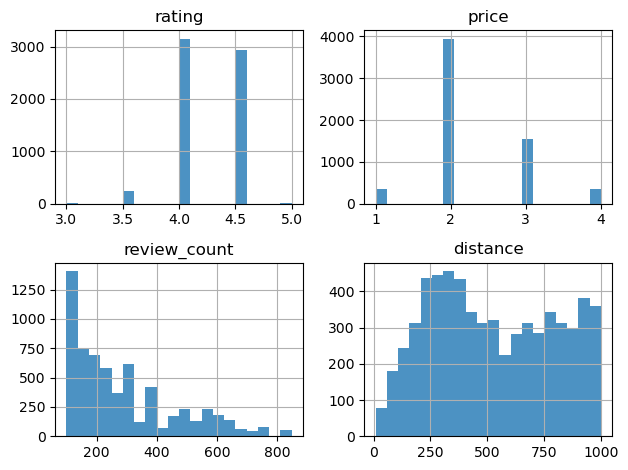

In [43]:
filtered_businesses = (
    df_businesses[
        (df_businesses['rating'] >= 3) & 
        (df_businesses['review_count'].between(100, 1000))
    ]
)
# Histogram of each variables (filtered data)
plt.figure(figsize=(12, 8))
filtered_businesses[['rating', 'price', 'review_count', 'distance']].hist(bins=20, alpha=0.8)
plt.tight_layout()

In [44]:
# Create csv file
df_businesses.to_csv('../data/yelp_businesses.csv', index=False)

# Comparing Results

#### Which API provided you with more complete data? Provide an explanation. 

In [45]:
# Import csv from sources
# Foursquare
fsq_poi = pd.read_csv('../data/fsq_businesses.csv', index_col=None)
# Yelp
yelp_poi = pd.read_csv('../data/yelp_businesses.csv', index_col=None)
# Stations
stations = pd.read_csv('../data/stations.csv', index_col=None)

In [46]:
fsq_poi.head()

,fsq_id,name,s_lat,s_lon,p_lat,p_lon,category_id,category_name,distance,rating,popularity,price
0,4cb240b8cbab236ae154af73,Restaurant Prima Luna,45.6175,-73.606011,45.617439,-73.593995,13236,Italian Restaurant,941,7.4,0.985,1.0
1,4e0b48221f6edc06be259aec,Salle Désilets,45.6175,-73.606011,45.617818,-73.606000,10039,Music Venue,19,NaN,0.969,NaN
2,4e0b48221f6edc06be259aec,Salle Désilets,45.6175,-73.606011,45.617818,-73.606000,11130,Office Building,19,NaN,0.969,NaN
3,4ea9b28cb803cf1ffacd7c0d,Café l'Exil,45.6175,-73.606011,45.617214,-73.604961,13034,Café,79,NaN,0.869,1.0
4,4ea9b28cb803cf1ffacd7c0d,Café l'Exil,45.6175,-73.606011,45.617214,-73.604961,13035,Coffee Shop,79,NaN,0.869,1.0


In [47]:
yelp_poi.head()

,id,name,rating,price,review_count,s_lat,s_lon,p_lat,p_lon,category_alias,distance
0,vRJPrk-VH75uxLiVVprBhA,Capucine,5.0,NaN,4,45.6175,-73.606011,45.619670,-73.609704,italian,375
1,TyKGLi1V1PFRHYmHDjFUMQ,Restaurant Prima Luna,4.0,3.0,14,45.6175,-73.606011,45.617234,-73.594176,italian,921
2,TyKGLi1V1PFRHYmHDjFUMQ,Restaurant Prima Luna,4.0,3.0,14,45.6175,-73.606011,45.617234,-73.594176,sushi,921
3,DOVOYnq3y-milXVI03GIrg,Boulangerie Adriatica,4.0,NaN,1,45.6175,-73.606011,45.615210,-73.609710,italian,366
4,DOVOYnq3y-milXVI03GIrg,Boulangerie Adriatica,4.0,NaN,1,45.6175,-73.606011,45.615210,-73.609710,pizza,366


In [48]:
stations.head()

,station_name,latitude,longitude,total_bikes,station
0,de la Commune / Place Jacques-Cartier,45.507610,-73.551836,78,0
1,de la Commune / King,45.497504,-73.552845,62,1
2,Jeanne-Mance / René-Lévesque,45.506371,-73.564201,55,2
3,Métro Viau (Viau / Pierre-de-Coubertin),45.563084,-73.548194,50,3
4,Métro Peel (de Maisonneuve / Stanley),45.500380,-73.575070,48,4


#### Comparing number of results per station

Since stations are determined by a combination of 'latitude' and 'longitude' and the long decimal values are hard to manage when comparing dataframe, we will use the station number as reference.

In [49]:
# Create the 'station' column using a dictionary
# locations dictionary
locations = stations.set_index(['latitude', 'longitude'])['station'].to_dict()

In [50]:
# stations columns
fsq_poi['station'] = fsq_poi.apply(lambda row: locations.get((row['s_lat'], row['s_lon']), 9999), axis=1)
yelp_poi['station'] = yelp_poi.apply(lambda row: locations.get((row['s_lat'], row['s_lon']), 9999), axis=1)

# Save these columns in original csv file for future use
fsq_poi.to_csv('../data/fsq_businesses.csv', index=False)
yelp_poi.to_csv('../data/yelp_businesses.csv', index=False)

In [51]:
# Each POI can have multiple categories, filter only unique businesses
yelp = (
    yelp_poi
    .drop_duplicates(subset=['station', 'id']) # each business as a unique id
    .groupby(['station'])
    .size().reset_index(name='count').sort_values(by='count', ascending=False)
)

fsq = (
    fsq_poi
    .drop_duplicates(subset=['station', 'fsq_id']) # each business as a unique fsq_id
    .groupby(['station'])
    .size().reset_index(name='count').sort_values(by='count', ascending=False)
)
# Merge and compare the number of businesses around each station
compare_yelp_fsq = pd.merge(yelp, fsq, on='station', how='outer', suffixes=('_yelp', '_fsq')) #outer, to see if some stations are not covered

In [52]:
compare_yelp_fsq.sort_values('station').head()

,station,count_yelp,count_fsq
0,0,20.0,49
58,1,20.0,48
143,2,20.0,49
564,3,15.0,49
135,4,20.0,50


Yelp seems to provide less POI than FSQ per locations (maybe an internally limit to ⋍ 20???).
Let's compare the quality of data for the station with the higher total of bikes (station 0).

In [53]:
# Select station 0 and remove duplicate of id because of category
yelp_qual_0 = yelp_poi[yelp_poi['station'] == 0].drop_duplicates(subset=['id'])
fsq_qual_0 = fsq_poi[fsq_poi['station'] == 0].drop_duplicates(subset=['fsq_id'])

In [54]:
print(yelp_qual_0.sort_values('rating', ascending=False).head(10))

                          id                     name  rating  price  \
1884  Ht-_i0UAq7YDBaqJwcQMdQ  Le Club Chasse et Pêche     4.5    4.0   
1904  uaf_yrwWo35aWM0_qJCgrw                 Pincette     4.5    3.0   
1924  ja01cHy1xqUB9DQ1r1OYKQ                   Gibbys     4.5    4.0   
1921  XI3iNUgChOfJk5ppjKVEQQ                  Barroco     4.5    3.0   
1918  9rT_Zr_A2qYmLaHpSi6eqw        Maison Saint-Paul     4.5    3.0   
1916  4eVPP9Qrq2lUYv0dOipIXQ            Un Po' Di Più     4.5    NaN   
1913  eJ9L40jm5VOXCIq7xs9kQw     Restaurant Bonaparte     4.5    3.0   
1907  QOlpCzJnVdcnxAmuIwdtEQ         Lattuca Barbecue     4.5    2.0   
1898  BCSofuQwu1VE8wjzDaQ3qQ             The Coldroom     4.5    2.0   
1926  soyZpe78MCeVN-0a11zSdQ                 Monarque     4.5    NaN   

      review_count     s_lat      s_lon      p_lat      p_lon  category_alias  \
1884           234  45.50761 -73.551836  45.508930 -73.552410          french   
1904            34  45.50761 -73.551836  45.5

In [55]:
print(fsq_qual_0.sort_values('rating', ascending=False).head(10))

                        fsq_id                    name     s_lat      s_lon  \
4335  56e9cf37498e8d07ac01d8f4  Crew Collective & Café  45.50761 -73.551836   
4330  4adf0b0ef964a5203d7721e3       Olive & Gourmando  45.50761 -73.551836   
4321  4ad4c06df964a5206ffa20e3              Stash Café  45.50761 -73.551836   
4304  5aee235b947c05002ca7bd54      Paquebot Vieux-Mtl  45.50761 -73.551836   
4326  58ac82d42980db353baa5cdd                 Mandy's  45.50761 -73.551836   
4352  57a1fa72498ef754ac40c539  La Finca café & bureau  45.50761 -73.551836   
4297  55777789498e80fb292f9b8a            Pub BreWskey  45.50761 -73.551836   
4290  4b391e12f964a5208c5625e3    L'Usine de Spaghetti  45.50761 -73.551836   
4346  4ff32280e4b0444717c09497      Deli Italien Bello  45.50761 -73.551836   
4338  5372ed9f498e6f504d4fe05d   Bar le Mal Nécessaire  45.50761 -73.551836   

          p_lat      p_lon  category_id                category_name  \
4335  45.502313 -73.559169        13034                   

Both API gives completely different result:
- Yelp:
    - Provides a low scale rating (1-5), while providing a review count.
    - Provides a price range in dollars signs category (that we had to convert).
    - We could have get more attributes, but these are 'Premium Access' like:
        - parking_bike - businesses with bike parking type.
        - outdoor_seating - businesses with outdoor seating areas.
    
- FSQ:
    - Provides high scale rating (1-10), but no review count.
    - Provides attribute like popularity (%) and price category from 1 to 4 (some missing data).


In [56]:
# Lets compare distance value
print(fsq_qual_0[fsq_qual_0['name'] == 'Jardin Nelson'][['s_lat', 's_lon', 'distance']])
print(yelp_qual_0[yelp_qual_0['name'] == 'Jardin Nelson'][['s_lat', 's_lon', 'distance']])

         s_lat      s_lon  distance
4291  45.50761 -73.551836        66
         s_lat      s_lon  distance
1894  45.50761 -73.551836        73


Using a distance calculator from the web, we find that Jardin Nelson is 79.5m from station:
- Yelp is 13.5m offset
- FSQ is 6.5m offset
<br><br>
FSQ distance calculator seems more precise than Yelp.

#### Get the top 10 restaurants according to their rating

In [57]:
fsq_resto= fsq_poi[fsq_poi['category_id'] >= 13000].drop_duplicates(subset=['fsq_id'])
print(fsq_resto.sort_values('rating', ascending=False).head(10))

                         fsq_id                    name      s_lat      s_lon  \
56     56ec4544498e27e294330c2b                   Cadet  45.516926 -73.564257   
52     4d920503f5388cfa1a81c23d           Bouillon Bilk  45.516926 -73.564257   
34979  54c3ca91498ec42c959c1f36         Mamie Clafoutis  45.570625 -73.651786   
1184   4adf0b0ef964a5203d7721e3       Olive & Gourmando  45.507144 -73.555119   
12503  55a86753498ee54a8b686b1e                   Damas  45.523026 -73.601840   
2848   56edffc9cd10ffe7a54b492c          La Bête à Pain  45.497165 -73.559330   
1180   56e9cf37498e8d07ac01d8f4  Crew Collective & Café  45.507144 -73.555119   
980    4aeaf971f964a52002bd21e3         Au Kouign-Amann  45.526890 -73.572640   
5158   4adb932bf964a5201b2921e3             Cafe Italia  45.535190 -73.615482   
2774   55f46d6c498e302d8870255e     Falafel St. Jacques  45.446061 -73.650799   

           p_lat      p_lon  category_id       category_name  distance  \
56     45.510388 -73.564365       

In [58]:
yelp_resto = yelp_poi.drop_duplicates(subset=['id'])
print(yelp_resto.sort_values(['rating', 'review_count'], ascending=False).head(10))

                           id                       name  rating  price  \
14147  evTWdlBsQl6EMiVcm0fXww              Cloakroom Bar     5.0    3.0   
2040   yLVW9xxnX8se7IFCDppdkw          Café de' Mercanti     5.0    1.0   
9629   I4KLIuqnYu_zPV6RCfEtQg             Pasta da Panza     5.0    2.0   
9054   Vlg_nesyZJfX_mpy2fslTQ                 Le Marquis     5.0    2.0   
12653  0o8kO3S4Khl_lIqrdk67ig                  Ono Pokii     5.0    NaN   
3456   RoNi0USDhvCBvXa4bMyxDA                  Mr. Puffs     5.0    1.0   
2595   Rx7E8hZQXcSjeHPGUZCeBg  Casse-Croûte Sissi & Paul     5.0    2.0   
1256   uH4-Esv5-b31q2y89AqyAw               Place Carmin     5.0    NaN   
4128   aLubn-yEUrbL3vlvzK3lVw    Che Churros & Empanadas     5.0    NaN   
12657  AQuvwHokJgcv1kchsZqKqg                    Toucheh     5.0    2.0   

       review_count      s_lat      s_lon      p_lat      p_lon  \
14147           187  45.496830 -73.579130  45.499440 -73.577860   
2040             74  45.510860 -73.54983

FSQ:<br>
Its easy to filter 'restaurant' with FSQ since we have different level of category_id from the API documentation. The rating is wide enough to use only this filter.
<br><br>
YELP:<br>
To be able to see proper top list, we need to consider review_count, which is the primary attribute of the API.
Also, it looks like the best rating/review 'restaurant' are fastfoods POI...

# CONCLUSION

Reminder: The city of choice is Montreal and the citybikes API provides information about the BiXi company (bike rental).

Beeing a Montrealer myself, I know people and tourist won't rent a bike because they want to access a fastfood restaurant! There is so many other restaurant options and point of interests.

My choice would be to use FSQ only data because:<br>
    - More POI (Art & Entertainement, Dining & Restaurant were selected)<br>
    - Rating is wide (1-10)<br>
    - Price range usable (1-4)<br>
    - Easy to differentiate category (could even go deeper and model each category using API documentation)